In [1]:
try:
    import davos
except:
    %pip install davos
    import davos
davos.config.suppress_stdout = True

In [2]:
smuggle requests                                            # pip: requests==2.28.2
from tqdm smuggle tqdm                                      # pip: tqdm==4.65.0
smuggle pandas as pd                                        # pip: pandas==2.0.1
smuggle numpy as np                                         # pip: numpy==1.25.2
smuggle seaborn as sns                                      # pip: seaborn==0.12.2
from matplotlib smuggle pyplot as plt                       # pip: matplotlib==3.7.1
from IPython.display smuggle Markdown
smuggle openpyxl                                            # pip: openpyxl==3.1.2
smuggle contractions                                        # pip: contractions==0.1.73
from nltk.tokenize smuggle word_tokenize, sent_tokenize     # pip: nltk==3.8.1
from nltk smuggle pos_tag
from scipy.stats import ttest_1samp                         # pip: scipy==1.11.2

smuggle nltk
nltk.download('averaged_perceptron_tagger', quiet=True)

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
smuggle pickle
smuggle zipfile
from glob smuggle glob as lsdir
from collections import defaultdict
from pathlib smuggle Path

# Predicting references to past and future events

At a high level, the goal of this meta analysis is to predict in-text references to past and future events.  Manually identifying these references is labor and time intensive, so it is impractical to scale up manual tagging to millions of documents.  Instead, we've defined some heuristics for *predicting* when text is referring to real or hypothetical past or future events.  Our approach comprises four main steps:

1. First we use the `nltk` package to segment each document into individual sentences. Each sentence is processed independently of the others.
2. Next, we handle contractions using the `contractions` package (e.g., "we'll" gets split into "we will," and so on).
3. Third, we define two sets of "keywords" (words and phrases) that tend to be indicative of referring to the past (`past_keywords.txt`) or future (`future_keywords.txt`).  We used ChatGPT (`gpt-4`) to generate each list, with exactly 50 templates per list, using the following prompt:
```
I'm designing a heuristic algorithm for identifying references (in text) to past and future events. Part of the algorithm will involve looking for specific keywords or phrases that suggest that the text is referring to something that happened (or will happen) in the past and/or future. Could you help me generate a list of 50 keywords or phrases to include in each list (one list for identifying references to the past and a second list for identifying references to the future)? I'd like to be able to paste the lists you generate into two plain text documents with one row per keyword or phrase, and no other content. Please output the lists as a "code" block (enclosed by ```...```).
```
4. Finally, we use part-of-speech tagging (using the `nltk` package) to look for verbs or verb phrases that are in past or future tenses. After the words are tagged with their predicted parts of speech, we use regular expressions (applied to the sequences of tags) to label each verb or verb phrase with a human readable verb form (e.g., "future perfect continuous passive," "conditional perfect continuous passive," and so on).

We treat each keyword match (of past or future keywords) as a single "reference" (to a past or future event, respectively), and if any past or future verb forms are detected we treat those as (up to) one additional reference.  We then tally up the numbers of past and/or future references across sentences within the document.

The `process_folder` function returns two things:
  - `df_results` is a DataFrame with one row per document (index), and the following columns:
    - `Past`: the number of references to past events identified in the document
    - `Future`: the number of references to future events identified in the document
  - `sent_results` is a dictionary whose keys are filenames of .txt files in the given folder, and whose values are DataFrames with one row per sentence in the given document.  The per-document DataFrames have the following columns:
    - `content`: the text of the given sentence
    - `past`: the number of references to past events identified in the given sentence
    - `future`: the number of references to future events identified in the given sentence

In the metaanalysis reported in our paper, we only use results from the `df_results` DataFrames.  However, the `sent_results` dictionaries are useful for spot-checking how the heuristics are working, and for digging into results for any given document(s).

Running the `process_folder` function can take a long time if there are many documents to process.  We save out the results as pickle files after running the function for the first time on a given directory so that the analysis only needs to be run one time per folder.

In [3]:
def load_keywords(filename):
    with open(filename, 'r') as f:
        return set(line.strip() for line in f)


def handle_contractions(sentence):
    return contractions.fix(sentence)


def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = pos_tag(text)
  return tense_detect(tagged)


def analyze_sentence(sentence, past_keywords, future_keywords):
    past_count = 0
    future_count = 0

    sentence = handle_contractions(sentence)
    
    # Check for past and future keywords
    past_kw_found = any(keyword in sentence for keyword in past_keywords)
    future_kw_found = any(keyword in sentence for keyword in future_keywords)

    # Count up to one past and/or future reference based on keywords
    past_count += int(past_kw_found)
    future_count += int(future_kw_found)
    
    # Also look at tenses
    tenses = sentence_tense(sentence)
    if any(['past' in x for x in tenses]):
        past_count += 1
    if any(['future' in x for x in tenses]) or any(['conditional indefinite' in x for x in tenses]):
        future_count += 1

    return past_count, future_count


def process_folder(folder_path, past_keywords, future_keywords):    
    # Dictionary to store results
    results_dict = defaultdict(lambda: {"Past": 0, "Future": 0})
    sentence_dfs = {}

    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith(".txt"):
            with open(os.path.join(folder_path, file_name), 'r', encoding="utf-8") as f:
                content = f.read()
                sentences = nltk.sent_tokenize(content)

                # Dataframe to store results for each sentence in the current file
                df = pd.DataFrame(columns=["content", "past", "future"])

                for sentence in sentences:
                    past_count, future_count = analyze_sentence(sentence, past_keywords, future_keywords)
                    results_dict[file_name]["Past"] += past_count
                    results_dict[file_name]["Future"] += future_count
                    df = df._append({"content": sentence, "past": past_count, "future": future_count}, ignore_index=True)

                sentence_dfs[file_name] = df

    df_results = pd.DataFrame(results_dict).T

    return df_results, sentence_dfs

## Keywords that reflect past events

In [4]:
past_keywords = load_keywords(str(Path.cwd().parent.joinpath('data', 'past_keywords.txt')))
Markdown('**Past keywords and phrases:**\n\n' + ' | '.join(past_keywords))

**Past keywords and phrases:**

bygone | up to now | back when | antiquity | used to be | before | once | last quarter | then | yesteryear | had | last night | terminated | thus far | last time | final | olden days | were | heretofore | in those days | in the past | so far | was | historically | long ago | last semester | yesterday | expired | to date | concluded | recently | elapsed | previously | last season | last week | since | last year | hitherto | wrote | last month | used to | already | ceased | formerly | earlier | ago | said | made | did | once upon a time

## Keywords that reflect future events

In [5]:
future_keywords = load_keywords(str(Path.cwd().parent.joinpath('data', 'future_keywords.txt')))
Markdown('**Future keywords and phrases:**\n\n' + ' | '.join(future_keywords))

**Future keywords and phrases:**

next quarter | next year | later on | in the cards | later | next week | next semester | hereafter | tomorrow | plan to | eventually | scheduled to | could | impending | next season | next month | after | upcoming | shortly | in the works | going to | futuristic | looming | down the line | soon | subsequent | predicted | on the horizon | can | some day | succeeding | prospective | may | forthcoming | eventual | next time | might | shall | will | to be | in the future | anticipated | in time | intend to | imminently

# Download the data

We'll examine 12 datasets that span several broad categories of documents: *film* (transcripts of movies or excerpts of transcripts from movies), *television* (transcripts of television shows or excerpts of transcripts from television shows), *speech* (transcripts of spoken communication), and *text* (written works or conversations that took place using text-based media).

The datasets are summarized in the DataFrame below:

In [6]:
data_list = Path.cwd().parent.joinpath('data', 'metaanalysis-datasets.xlsx')
data = pd.read_excel(data_list)
data

,Dataset,Short name,Data URL,Source URL,Results URL,Description,Category,Number of observations,Observation type,Number of words
0,Internet Movie Script Database,IMSDb,https://www.dropbox.com/scl/fi/ct39vqqq9sjqyyh...,https://imsdb.com,https://www.dropbox.com/scl/fi/3gq5ieq7l25719i...,A collection of transcripts from roughly 1000 ...,Film,1091,Transcript,26023348
1,Movie Dialogues Dataset,Movies,https://www.dropbox.com/s/881yuhil48v6q1n/movi...,https://convokit.cornell.edu/documentation/mov...,https://www.dropbox.com/scl/fi/arxkyhub2fi6qh5...,A large collection of fictional conversations ...,Film,304713,Utterance,3209921
2,Switchboard Dialog Act Corpus,Switchboard,https://www.dropbox.com/s/qvx4211u41l2ex4/swit...,https://convokit.cornell.edu/documentation/swi...,https://www.dropbox.com/scl/fi/1o7wqdlc1oo26y6...,A collection of five-minute telephone conversa...,Speech,122646,Utterance,2052779
3,Supreme Court Corpus,SCOTUS,https://www.dropbox.com/s/icxk3ubo2u2brzq/supr...,https://convokit.cornell.edu/documentation/sup...,https://www.dropbox.com/scl/fi/zxkvlrg4lfxcv7c...,A collection of cases from the U.S. Supreme Co...,Speech,1700789,Utterance,71889094
4,Tennis Interviews,Tennis,https://www.dropbox.com/s/q7bfirllnu32mao/tenn...,https://convokit.cornell.edu/documentation/ten...,https://www.dropbox.com/scl/fi/d3g83mtz4mqhbpm...,Transcripts for tennis singles post-match pres...,Speech,163948,Utterance,7043118
5,Persuasion for Good Corpus,PfG,https://www.dropbox.com/scl/fi/ei7uxv9husg9noj...,https://convokit.cornell.edu/documentation/per...,https://www.dropbox.com/scl/fi/zmumd8uno58cqzo...,A collection of online conversations generated...,Speech,20932,Utterance,351759
6,Intelligence Squared Debates Corpus,IQ2,https://www.dropbox.com/scl/fi/srg1j0m4rhgoqhl...,https://convokit.cornell.edu/documentation/iq2...,https://www.dropbox.com/scl/fi/3d4eha6r6xop7h0...,This dataset contains transcripts of debates h...,Speech,26562,Utterance,1898509
7,Group Affect and Performance Corpus,GAP,https://www.dropbox.com/scl/fi/j1zh1pey7m8kcyr...,https://convokit.cornell.edu/documentation/gap...,https://www.dropbox.com/scl/fi/prk03sodn4pg895...,Group members completed a Winter Survival Task...,Speech,8009,Utterance,45989
8,The Chair,Chair,https://www.dropbox.com/scl/fi/9cpj3t1n1ktxghu...,https://scrapsfromtheloft.com/?s=THE+CHAIR,https://www.dropbox.com/scl/fi/to0642t939pvrtz...,"Scraped transcripts from The Chair, Season 1.",Television,6,Transcript,19197
9,Friends Corpus,Friends,https://www.dropbox.com/s/nfaa6ap0ws1rqjy/frie...,https://convokit.cornell.edu/documentation/fri...,https://www.dropbox.com/scl/fi/mkxc114g90rifsm...,A collection of all the conversations that occ...,Television,67373,Utterance,622894


# Detect past and future events

For each dataset in the `data` DataFrame, we'll:
  - Download and extract the dataset if it doesn't already exist locally
  - Check to see whether the metaanalysis has already been run on that folder.  If not, we'll run the `process_folder` function on the dataset's directory and save the results

In [7]:
def get_folder_name(url):
    return [s for s in url.split('/') if '.zip' in s][0].split('?')[0][:-4]

def download_dataset(url, outdir):
    # Download dataset
    filename = get_folder_name(url) + '.zip'
    x = requests.get(url)

    with open(filename, 'wb') as f:
        f.write(x.content)
    
    # Unzip dataset
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(outdir)

    # Delete zip file
    os.remove(filename)

In [8]:
datadir = Path.cwd().parent.joinpath('data')
results = []

# should we just download the already-completed results or compute them from scratch?
force_rerun = False

for i, row in data.iterrows():
    print('Processing dataset: ' + row['Dataset'])
    results_fname = datadir.joinpath(row['Short name'].lower() + '_results.pkl')
    if not results_fname.exists():
        if force_rerun:
            # check whether the dataset exists locally and has at least 5 .txt files
            next_datadir = datadir.joinpath(get_folder_name(row['Data URL']))
            if not (next_datadir.exists() and len(lsdir(str(next_datadir.joinpath('*.txt')))) >= 5):
                # download the dataset
                download_dataset(row['Data URL'], datadir)
            
            # process the dataset
            df_results, sentence_dfs = process_folder(next_datadir, past_keywords, future_keywords)
            with open(results_fname, 'wb') as f:
                pickle.dump([df_results, sentence_dfs], f)
        else:
            x = requests.get(row['Results URL'])
            with open(results_fname, 'wb') as f:
                f.write(x.content)
    
    with open(results_fname, 'rb') as f:
        next_results, _ = pickle.load(f)
    
    next_results = next_results.reset_index().rename(columns={"index": "filename"}).melt(id_vars=["filename"], var_name="tense", value_name="count")
    next_results['proportion'] = next_results['count'] / next_results.groupby('filename')['count'].transform('sum')
    next_results['Dataset'] = row['Short name']

    results.append(next_results)

results = pd.concat(results)

Processing dataset: Internet Movie Script Database


Processing dataset: Movie Dialogues Dataset
Processing dataset: Switchboard Dialog Act Corpus
Processing dataset: Supreme Court Corpus
Processing dataset: Tennis Interviews
Processing dataset: Persuasion for Good Corpus
Processing dataset: Intelligence Squared Debates Corpus
Processing dataset: Group Affect and Performance Corpus
Processing dataset: The Chair
Processing dataset: Friends Corpus
Processing dataset: Gutenberg Dialogue Dataset
Processing dataset: Reddit Corpus


Load in manual counts for *The Chair*

In [9]:
# make sure the chair dataset has been downloaded
chair_url = data.query('Dataset == "The Chair"')['Data URL'].values[0]
chair_datadir = datadir.joinpath(get_folder_name(chair_url))
if not (chair_datadir.exists() and len(lsdir(str(chair_datadir.joinpath('*.txt')))) >= 5):
    download_dataset(chair_url, datadir)

# fill in proportions for manual reference counts
ref_fname = str(Path.cwd().parent.joinpath('data', 'the_chair', 'the_chair_manual_reference_counts.csv'))
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='count', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual.reset_index(inplace=True, drop=True)
manual['proportion'] = manual['count'] / manual.groupby('Episode')['count'].transform('sum')
manual

,Episode,tense,count,proportion
0,1,Past,60,0.769231
1,1,Future,18,0.230769
2,2,Past,30,0.681818
3,2,Future,14,0.318182
4,3,Past,43,0.565789
5,3,Future,33,0.434211
6,4,Past,31,0.596154
7,4,Future,21,0.403846
8,5,Past,36,0.765957
9,5,Future,11,0.234043


Load automatically identified counts from *The Chair*

In [10]:
chair_fname = str(Path.cwd().parent.joinpath('data', 'chair_results.pkl'))
with open(chair_fname, 'rb') as f:
    chair_results, _ = pickle.load(f)

auto = chair_results.reset_index().rename(columns={"index": "filename"}).melt(id_vars=["filename"], var_name="tense", value_name="count")
auto['Episode'] = auto['filename'].apply(lambda filename: int(filename.split('_')[2][3]))
auto['proportion'] = auto['count'] / auto.groupby('Episode')['count'].transform('sum')
auto.sort_values(by=['Episode'], inplace=True)
auto.drop(columns=['filename'], inplace=True)
auto.reset_index(drop=True, inplace=True)
auto

,tense,count,Episode,proportion
0,Past,152,1,0.575758
1,Future,112,1,0.424242
2,Past,108,2,0.529412
3,Future,96,2,0.470588
4,Past,177,3,0.608247
5,Future,114,3,0.391753
6,Past,148,4,0.594378
7,Future,101,4,0.405622
8,Past,164,5,0.616541
9,Future,102,5,0.383459


# Create meta-analysis figure

- Panel A: Numbers of (manually and automatically detected) past and future events from each episode of *The Chair*, season 1.
- Panel B: Proportions of (manually and automatically detected) past and future events from each episode of *The Chair*, season 1.
- Panel C: Proportions of automatically detected past and future events from each dataset

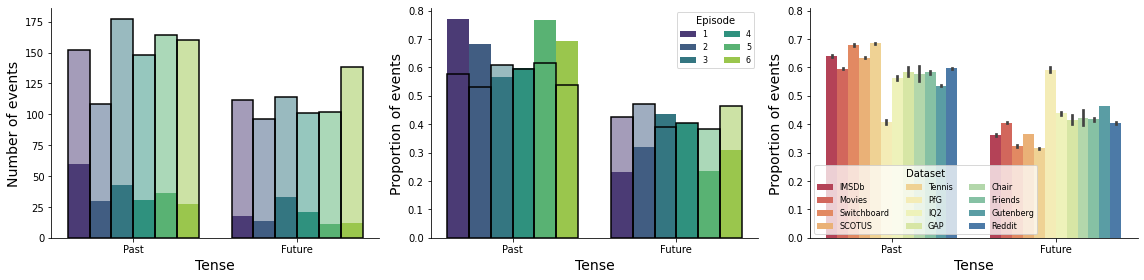

In [11]:
fig, axes = plt.subplots(figsize=(16, 4), ncols=3)

# panel A
sns.barplot(data=manual, x='tense', y='count', hue='Episode', palette='viridis', ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', palette='viridis', alpha=0.5, ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[0])
axes[0].get_legend().remove()

axes[0].set_xlabel('Tense', fontsize=14)
axes[0].set_ylabel('Number of events', fontsize=14)
sns.despine(top=True, right=True)


# panel B
sns.barplot(data=manual, x='tense', y='proportion', hue='Episode', palette='viridis', ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', palette='viridis', alpha=0.5, ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(loc='upper right', title='Episode', handles=handles[:6], labels=labels[:6], frameon=True, framealpha=0.75, ncol=2, fontsize=8)

axes[1].set_xlabel('Tense', fontsize=14)
axes[1].set_ylabel('Proportion of events', fontsize=14)
sns.despine(top=True, right=True)


# panel C
sns.barplot(results, x='tense', y='proportion', hue='Dataset', palette='Spectral', ax=axes[2])
axes[2].set_xlabel('Tense', fontsize=14)
axes[2].set_ylabel('Proportion of events', fontsize=14)
axes[2].legend(loc='lower left', title='Dataset', frameon=True, ncol=3, fontsize=8, facecolor='white', framealpha=0.75)
axes[2].set_ylim(axes[1].get_ylim())
sns.despine(top=True, right=True)


plt.tight_layout()
plt.savefig('meta-analysis.pdf', bbox_inches='tight')

# Include some stats (to report in the main text)

Total number of observations and words across all datasets

In [12]:
x = data.sum()
print(f"There are a total of {x['Number of observations']} observations across all datasets.")
print(f"There are a total of {x['Number of words']} words across all datasets.")

There are a total of 17264278 observations across all datasets.
There are a total of 443756731 words across all datasets.


Proportion of past versus future events, across all documents

In [13]:
# print the numbers and proportions of past and future events, across all documents

n_past = results.query('tense == "Past"')['count'].sum()
n_future = results.query('tense == "Future"')['count'].sum()
n_total = n_past + n_future

print(f"Past events: {n_past} ({n_past / n_total:.2%})")
print(f"Future events: {n_future} ({n_future / n_total:.2%})")
print(f"Total events: {n_total}")

Past events: 19464741 (54.06%)
Future events: 16543759 (45.94%)
Total events: 36008500


T-test comparing proportions of past vs. future events across datasets

In [14]:
# average proportions of past events for each dataset
past_proportions = results.groupby('Dataset').apply(lambda x: x.query('tense == "Past"')['proportion'].mean()).sort_values(ascending=False)
x = ttest_1samp(past_proportions, 0.5)
print(f"Average proportion of past events: {past_proportions.mean():.2%} ± {past_proportions.std():.2%}")
print(f"t({x.df}) = {x.statistic:.2f}, p = {x.pvalue:.4f}")

Average proportion of past events: 58.99% ± 7.28%
t(11) = 4.28, p = 0.0013


Odds radios and confidence intervals (odds ratio = past refs / future refs)

In [34]:
def print_odds_ratio_stats(x, n_bootstraps=1000):
    odds_ratios = []

    for _ in range(n_bootstraps):
        # take a random sample from the dataset (with replacement)
        sample = x.sample(n=len(x), replace=True)

        # compute the odds ratio for the sample
        n_past = sample.query('tense == "Past"')['count'].sum()
        n_future = sample.query('tense == "Future"')['count'].sum()
        odds_ratio = n_past / n_future

        odds_ratios.append(odds_ratio)
    
    print(f'Average odds ratio: {np.mean(odds_ratios):.2f} ± {np.std(odds_ratios):.2f}')
    print(f'Odds ratio boostrap-estimated 95% CI: [{np.percentile(odds_ratios, 2.5):.2f}, {np.percentile(odds_ratios, 97.5):.2f}]')

In [36]:
debug = False  # set to True to print out quicker estimates
if debug:
    n_boostraps = 10
else:
    n_boostraps = 100

datasets = results['Dataset'].unique()

for d in datasets:
    past_proportions = results.query('Dataset == @d and tense == "Past"')['proportion']
    future_proportions = results.query('Dataset == @d and tense == "Future"')['proportion']

    odds_ratios = past_proportions / future_proportions

    print(f"\n{d}: ")
    print_odds_ratio_stats(results.query('Dataset == @d'), n_bootstraps=n_boostraps)


IMSDb: 
Average odds ratio: 1.76 ± 0.08
Odds ratio boostrap-estimated 95% CI: [1.61, 1.92]

Movies: 
Average odds ratio: 1.39 ± 0.01
Odds ratio boostrap-estimated 95% CI: [1.37, 1.40]

Switchboard: 
Average odds ratio: 1.93 ± 0.02
Odds ratio boostrap-estimated 95% CI: [1.90, 1.97]

SCOTUS: 
Average odds ratio: 1.71 ± 0.00
Odds ratio boostrap-estimated 95% CI: [1.71, 1.72]

Tennis: 
Average odds ratio: 2.31 ± 0.01
Odds ratio boostrap-estimated 95% CI: [2.29, 2.34]

PfG: 
Average odds ratio: 0.63 ± 0.01
Odds ratio boostrap-estimated 95% CI: [0.61, 0.65]

IQ2: 
Average odds ratio: 1.31 ± 0.03
Odds ratio boostrap-estimated 95% CI: [1.25, 1.37]

GAP: 
Average odds ratio: 1.40 ± 0.06
Odds ratio boostrap-estimated 95% CI: [1.28, 1.52]

Chair: 
Average odds ratio: 1.82 ± 1.36
Odds ratio boostrap-estimated 95% CI: [0.44, 6.17]

Friends: 
Average odds ratio: 1.34 ± 0.02
Odds ratio boostrap-estimated 95% CI: [1.31, 1.37]

Gutenberg: 
Average odds ratio: 1.07 ± 0.00
Odds ratio boostrap-estimated 